## Note

This is a follow up from a webinar hosted by CBOE: "Finding Edge: A Key Part of Trading Process"

The speaker, Euan Sinclair, gives an example of market displacement between VXN vs NDX. I found this webinar very insightful and it gave me a peak inside to the thought process behind generating ideas and following them up with trades.

I would like to explore this idea furter with other indexs.

In [143]:
import sys
import os
import datetime

import pandas as pd
import numpy as np

import yfinance as yf
from fredapi import Fred

import matplotlib.pyplot as plt



In [144]:
sys.path.append('/Users/lukelee/Documents/Interview/Learning/')

In [145]:
# custom modules that are present in this Git repo, written by me
import yahoo.code.support_functions as sf
import yahoo.code.plot_functions as pf

In [146]:
def extract_hist(symbol,period="max"):
    # find ticker
    ticker = yf.Ticker(symbol)
    Long_Name = ticker.info['longName']
    Symbol = ticker.info['symbol']
    print(f"{Long_Name=}")
    print(f"{Symbol=}")
    # get history
    hist = ticker.history(period)
    print(hist.iloc[:,0:4].tail(3))
    fmt = lambda x: pd.to_datetime(x).date()
    start_date = hist.index.min()
    end_date = hist.index.max()
    n = hist.shape[0]
    print("\n")
    print(f"Time Series data from {fmt(start_date)} to {fmt(end_date)}. Total of {n} observation")
    return hist, ticker
    

In [147]:
vix_hist, vix = extract_hist("^VIX")
# 30 day implied volatility of SPX Options

Long_Name='CBOE Volatility Index'
Symbol='^VIX'
                                Open       High    Low      Close
Date                                                             
2025-06-09 00:00:00-05:00  17.690001  17.719999  16.82  17.160000
2025-06-10 00:00:00-05:00  17.500000  17.990000  16.68  16.950001
2025-06-11 00:00:00-05:00  17.040001  18.090000  16.23  17.260000


Time Series data from 1990-01-02 to 2025-06-11. Total of 8927 observation


In [148]:
vxn_hist, vxn = extract_hist("^VXN")
# Cboe NASDAQ-100 Volatility Index

Long_Name='^VXN'
Symbol='^VXN'
                                Open       High        Low      Close
Date                                                                 
2025-06-09 00:00:00-04:00  20.719999  20.860001  19.850000  20.170000
2025-06-10 00:00:00-04:00  20.049999  20.559999  19.610001  19.820000
2025-06-11 00:00:00-04:00  19.320000  20.940001  19.219999  20.379999


Time Series data from 2001-01-23 to 2025-06-11. Total of 6132 observation


In [149]:
volndx_hist, volndx = extract_hist("^VOLNDX",period='5d')
# no data avaiable!

Long_Name='Volatility NASDAQ - 100'
Symbol='^VOLNDX'
                                   Open          High          Low  \
Date                                                                 
2025-06-11 00:00:00-04:00  10079.700195  10097.854492  9996.206055   

                                  Close  
Date                                     
2025-06-11 00:00:00-04:00  10028.821289  


Time Series data from 2025-06-11 to 2025-06-11. Total of 1 observation


In [150]:
volq_hist, volq = extract_hist("^VOLQ")
# very limited history in 2023 only

Long_Name='Nasdaq-100 Volatility Index VOL'
Symbol='^VOLQ'
                                Open       High        Low      Close
Date                                                                 
2023-09-27 00:00:00-04:00  20.870001  22.219999  20.790001  21.080000
2023-09-28 00:00:00-04:00  21.809999  22.059999  19.930000  20.320000
2023-09-29 00:00:00-04:00  19.450001  20.510000  18.780001  20.209999


Time Series data from 2023-06-26 to 2023-09-29. Total of 68 observation


In [151]:
import datetime

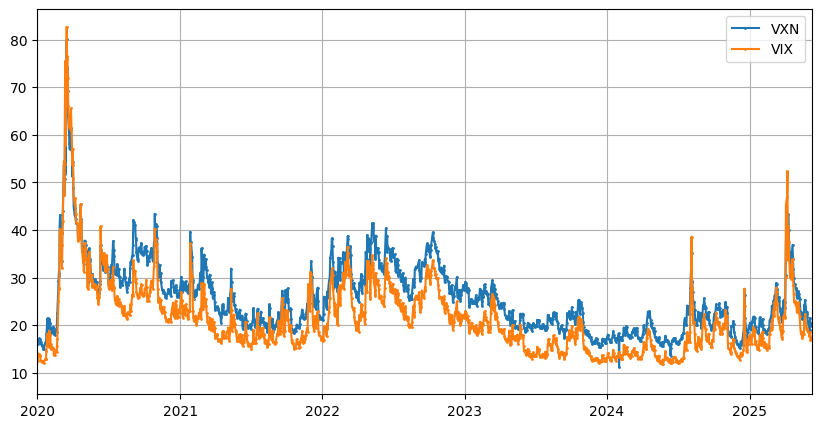

In [152]:
plt.figure(figsize=(10,5))


plt.plot(vxn_hist.index,vxn_hist.Close,label='VXN',marker='o',ms=1)
plt.plot(vix_hist.index,vix_hist.Close,label='VIX',marker='o',ms=1)

plt.xlim([datetime.date(2020,1,1),datetime.date(2025,6,11)])
plt.grid()
plt.legend()
plt.show()

In [155]:
df1 = calculate_ratio(ts_numer = vxn_hist, ts_denom = vix_hist)


            CloseNumerator  CloseDenominator     Ratio  Rolling30      Diff
Date                                                                       
2025-06-09       20.170000         17.160000  1.175408   1.155165  0.020242
2025-06-10       19.820000         16.950001  1.169321   1.156316  0.013005
2025-06-11       20.379999         17.260000  1.180765   1.157612  0.023153


In [154]:
def calculate_ratio(ts_numer,ts_denom):
    # compare ratio: merge data, drop na to get same hist, calculate ratio, compute stats
    # use date as index (i.e. remove time information)
    ts_numer.index = ts_numer.index.map(lambda x: pd.to_datetime(x).date())
    ts_denom.index = ts_denom.index.map(lambda x: pd.to_datetime(x).date())
    
    
    ts_data = ts_numer.loc[:,['Close']].join(ts_denom.loc[:,['Close']],how='inner',lsuffix='Numerator', rsuffix='Denominator')
    ts_data.loc[:,'Ratio'] = ts_data.CloseNumerator/ts_data.CloseDenominator
    
    ts_data.loc[:,'Rolling30'] = ts_data.Ratio.rolling(30).mean()
    ts_data.loc[:,'Diff'] = ts_data.Ratio - ts_data.Rolling30
    print(ts_data.tail(3))
    return ts_data


In [156]:
ts_data = df1

The 1% quantile of the differnece is -0.253


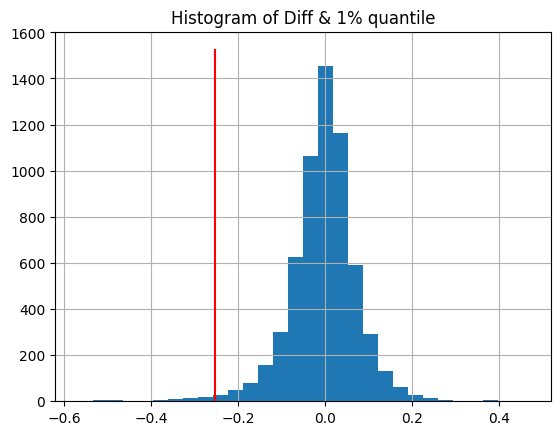

In [157]:
# observe the dislocation using the diff
threshold = np.quantile(ts_data.Diff.dropna().to_list(),0.01)
print(f"The 1% quantile of the differnece is {np.round(threshold,3)}")
plt.figure()
plt.hist(ts_data.Diff,30)
xlim = plt.ylim()
plt.vlines(threshold,xlim[0],xlim[1],'r')
plt.title('Histogram of Diff & 1% quantile')
plt.grid()
plt.show()

In [158]:
# summary stat of last 1 year
summary_data = ts_data.loc[:,['Ratio','Rolling30','Diff']].tail(252)
summary = summary_data.describe()
summary = summary.loc[['min','mean','max','std'],:]
print(summary)

         Ratio  Rolling30      Diff
min   0.755972   1.081028 -0.414833
mean  1.194325   1.202140 -0.007815
max   1.412983   1.342119  0.137199
std   0.096236   0.067950  0.076742


            CloseNumerator  CloseDenominator     Ratio  Rolling30      Diff
Date                                                                       
2018-02-05       33.020000         37.320000  0.884780   1.419267 -0.534486
2018-02-06       26.700001         29.980000  0.890594   1.405121 -0.514527
2018-02-07       24.730000         27.730000  0.891814   1.392626 -0.500812
2018-02-12       24.940001         25.610001  0.973838   1.355100 -0.381262
2018-02-13       23.709999         24.969999  0.949539   1.339408 -0.389869
2020-03-12       67.830002         75.470001  0.898768   1.152582 -0.253814
2024-02-01       11.200000         13.880000  0.806916   1.274559 -0.467642
2024-08-05       35.099998         38.570000  0.910034   1.324867 -0.414833
2025-04-04       37.650002         45.310001  0.830942   1.126980 -0.296037
2025-04-07       38.639999         46.980000  0.822478   1.116707 -0.294229
2025-04-08       39.560001         52.330002  0.755972   1.104198 -0.348226


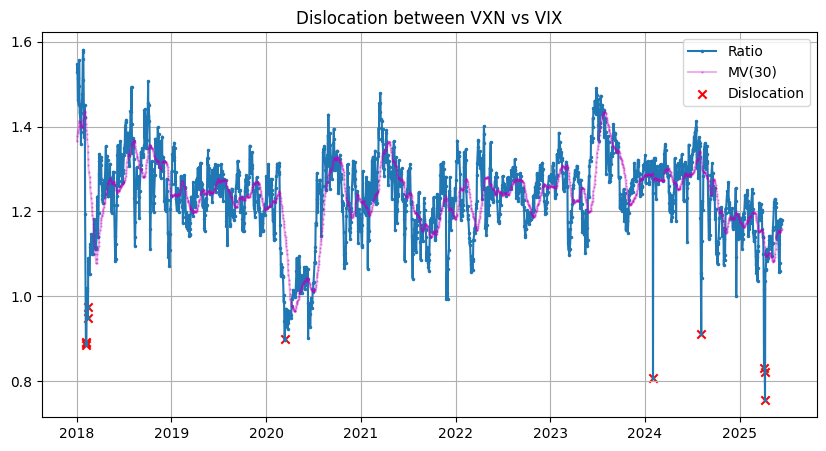

In [159]:
plt.figure(figsize=(10,5))
plot_data = ts_data.loc[ts_data.index >= datetime.date(2018, 1, 1),:]
plt.plot(plot_data.index,plot_data.Ratio,marker='o',ms=1.5,label='Ratio')

# rational: use last month of observations to calcualte an average
plt.plot(plot_data.index,plot_data.Rolling30,marker='.',ls=None,c='m',ms=1.5,alpha=0.3,label='MV(30)')

# identify dislocation, added additional conditions using Diff = Ratio - Rolling5
identifier = ts_data.loc[(ts_data.Diff<-0.25) & (ts_data.Ratio < 1),:]
print(identifier)
plt.scatter(identifier.index,identifier.Ratio,marker='x',c='r',label='Dislocation')
plt.legend()

plt.title("Dislocation between VXN vs VIX")

plt.grid()
plt.show()

## New ideas

Now that we have re-visited the topic discussed during the webinar, lets expand the analysis to other volatility indexes

In [160]:
fred = Fred(api_key=os.environ['FRED_API_KEY'])

In [165]:
# CBOE Russell 2000 Volatility Index (RVXCLS)
RVXCLS_data = pd.DataFrame(fred.get_series("RVXCLS"),columns=['Close'])

In [166]:
RVXCLS_data.tail()

,Close
2025-06-04,23.45
2025-06-05,24.08
2025-06-06,22.30
2025-06-09,22.92
2025-06-10,22.65


In [168]:
df2 = calculate_ratio(ts_numer = RVXCLS_data, ts_denom = vix_hist)


            CloseNumerator  CloseDenominator     Ratio  Rolling30      Diff
2025-06-06           22.30         16.770000  1.329755   1.213373  0.116382
2025-06-09           22.92         17.160000  1.335664   1.217450  0.118214
2025-06-10           22.65         16.950001  1.336283   1.223345  0.112938


In [169]:
ts_data = df2

The 0.5% quantile of the differnece is -0.249
The 99.5% quantile of the differnece is 0.205


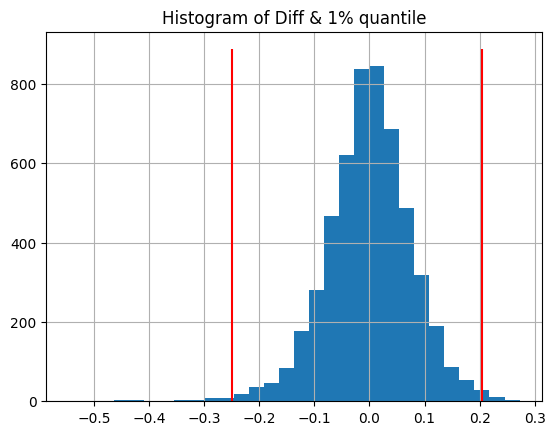

In [200]:
# observe the dislocation using the diff
threshold = np.quantile(ts_data.Diff.dropna().to_list(),0.005)
threshold_upper = np.quantile(ts_data.Diff.dropna().to_list(),1-0.005)
print(f"The 0.5% quantile of the differnece is {np.round(threshold,3)}")
print(f"The 99.5% quantile of the differnece is {np.round(threshold_upper,3)}")

plt.figure()
plt.hist(ts_data.Diff,30)
xlim = plt.ylim()
plt.vlines(threshold,xlim[0],xlim[1],'r')

plt.vlines(threshold_upper,xlim[0],xlim[1],'r')
plt.title('Histogram of Diff & 1% quantile')
plt.grid()
plt.show()

In [189]:
# summary stat of last 1 year
summary_data = ts_data.loc[:,['Ratio','Rolling30','Diff']].tail(252)
summary = summary_data.describe()
summary = summary.loc[['min','mean','max','std'],:]
print(summary)

         Ratio  Rolling30      Diff
min   0.864131   1.100678 -0.420615
mean  1.344951   1.358256 -0.013305
max   1.818044   1.551441  0.272308
std   0.164181   0.136897  0.108683


            CloseNumerator  CloseDenominator     Ratio  Rolling30      Diff
2018-02-05           34.49         37.320000  0.924169   1.368001 -0.443832
2018-02-06           23.96         29.980000  0.799199   1.345057 -0.545857
2018-02-07           22.36         27.730000  0.806347   1.324191 -0.517844
2018-02-08           27.90         33.459999  0.833831   1.304896 -0.471064
2018-02-09           27.85         29.059999  0.958362   1.290487 -0.332125
2018-02-12           21.63         25.610001  0.844592   1.272471 -0.427879
2018-02-13           20.21         24.969999  0.809371   1.254190 -0.444819
2018-02-14           18.94         19.260000  0.983385   1.239307 -0.255921
2018-02-15           18.29         19.129999  0.956090   1.221996 -0.265906
2018-02-16           17.96         19.459999  0.922919   1.203122 -0.280203
2024-07-16           23.98         13.190000  1.818044   1.545736  0.272308
2024-08-05           42.09         38.570000  1.091263   1.511878 -0.420615
2024-12-18  

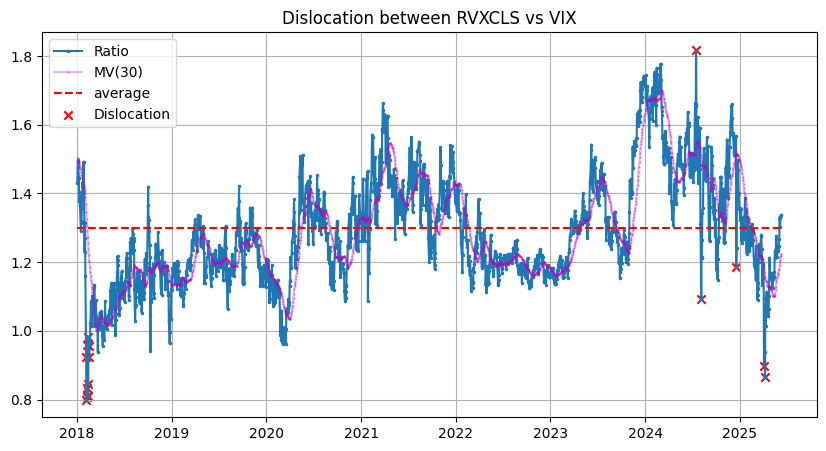

In [205]:
plt.figure(figsize=(10,5))
plot_data = ts_data.loc[ts_data.index >= datetime.date(2018, 1, 1),:]
plt.plot(plot_data.index,plot_data.Ratio,marker='o',ms=1.5,label='Ratio')

# rational: use last month of observations to calcualte an average
plt.plot(plot_data.index,plot_data.Rolling30,marker='.',ls=None,c='m',ms=1.5,alpha=0.3,label='MV(30)')

plt.hlines(1.3,datetime.date(2018,1,1),datetime.date(2025,6,11),'r',linestyles='--',label='average')

plt.legend()



# identify dislocation, added additional conditions using Diff = Ratio - Rolling5
condition_1 = (plot_data.Diff>0.2) & (plot_data.Ratio>1.7)
condition_2 = (plot_data.Diff<-0.25) & (plot_data.Ratio<1.2)
identifier = plot_data.loc[ condition_2 | condition_1,:]
print(identifier)
plt.scatter(identifier.index,identifier.Ratio,marker='x',c='r',label='Dislocation')
plt.legend()

plt.title("Dislocation between RVXCLS vs VIX")

plt.grid()
plt.show()

In [ ]:
# CBOE NASDAQ 100 Volatility Index (VXNCLS)
VXNCLS_data = pd.DataFrame(fred.get_series("VXNCLS"),columns=['Close'])